In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 19s 0us/step


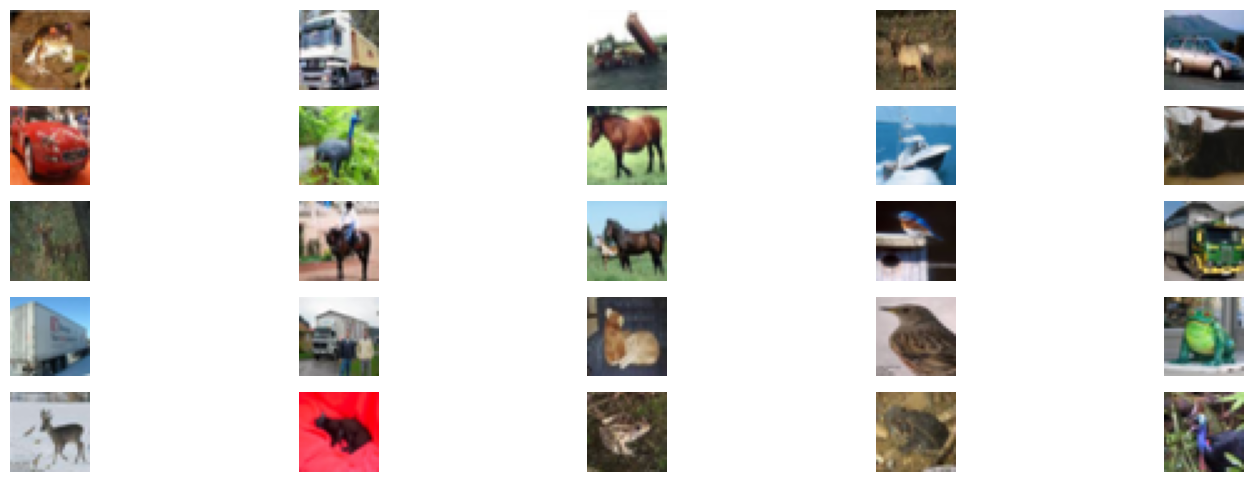

In [2]:
# Load and visualize the dataset
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]

# Display some sample images
def display_sample_images(images, num_images=25):
    plt.figure(figsize=(18,6))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.imshow((images[i] + 1) / 2)
        plt.axis('off')
    plt.show()

display_sample_images(x_train)

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_output, fake_output

def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_epoch = 0
        disc_loss_epoch = 0
        real_acc_epoch = 0
        fake_acc_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss, real_output, fake_output = train_step(image_batch)
            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            real_acc_epoch += tf.reduce_mean(tf.sigmoid(real_output))
            fake_acc_epoch += tf.reduce_mean(1 - tf.sigmoid(fake_output))

        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss_epoch / len(dataset)}, Discriminator Loss: {disc_loss_epoch / len(dataset)}, Real Accuracy: {real_acc_epoch / len(dataset)}, Fake Accuracy: {fake_acc_epoch / len(dataset)}')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # Rescale to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

train(train_dataset, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

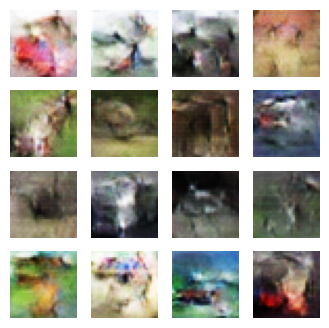

In [6]:
generate_and_save_images(generator, EPOCHS, seed)